import

In [1]:
# Importing Image class from PIL module
from PIL import Image
import os, sys
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt

import xml.etree.ElementTree as ET
from tqdm import tqdm 


List files in directory

In [2]:
base_path = '../data/cropped/combine'

# list all files in directory
files = sorted(os.listdir(base_path))
n_files = len(files)
print("Nr of files: ", n_files)
# print("Files: ", files)

Nr of files:  1200


Augmentation 1: flip

img_path:  ../data/cropped/combine\five_raw_0.png
img shape:  (408, 612, 3)


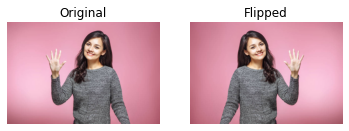

In [3]:
# demo
def vertical_flip(img):
    return cv2.flip(img, 1)

# load test img
img_path = os.path.join(base_path, files[0])
print("img_path: ", img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("img shape: ", np.shape(img))

# do vertical image flip
img_flip = vertical_flip(img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_flip)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Flipped')
plt.axis('off')
plt.show()

Augmentation 2: Brightness

img_path:  ../data/cropped/combine\five_raw_0.png
img shape:  (408, 612, 3)


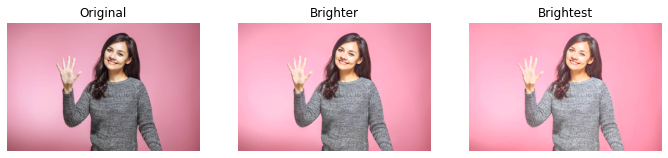

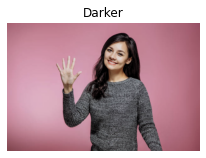

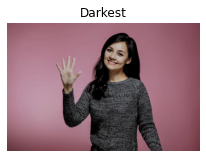

In [4]:
# demo
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if value > 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

    else:
        lim = 0 - value
        v[v < lim] = 0
        v[v >= lim] = v[v >= lim] + value


    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# load test img
img_path = os.path.join(base_path, files[0])
print("img_path: ", img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pixels = np.array(img)
print("img shape: ", np.shape(img))
img_cpy = img

# change brightness
img_brighter = increase_brightness(img, value=30)
img_brightest = increase_brightness(img_cpy, value=60)
img_darker = increase_brightness(img_cpy, value=-30)
img_darkest = increase_brightness(img_cpy, value=-60)

# original
plt.subplot(1, 5, 1,)
plt.imshow(img)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Original')
plt.axis('off')
# brightened
plt.subplot(1, 5, 2)
plt.imshow(img_brighter)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Brighter')
plt.axis('off')
# brightest
plt.subplot(1, 5, 3)
plt.imshow(img_brightest)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Brightest')
plt.axis('off')
plt.show()
# darker
plt.subplot(1, 5, 4)
plt.imshow(img_darker)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Darker')
plt.axis('off')
plt.show()
# darkest
plt.subplot(1, 5, 5)
plt.imshow(img_darkest)
plt.rcParams["figure.figsize"] = (20,15)
plt.title('Darkest')
plt.axis('off')
plt.show()


Create augmented dataset

In [5]:
# flip each file in the directory
files_xml = [f for f in files if f.endswith('.xml')]
files_img = [f for f in files if f.endswith('.png')]

# read xml and png files
n_images = len(files_img)
print("Nr of images: ", n_images)
n_xml = len(files_xml)
print("Nr of xml: ", n_xml)

assert n_images == n_xml
assert n_images + n_xml == n_files

# result directory
result_path = '../data/augmented'

# nr of data augmentations
brightness_set = [-60, -30, 0, 30, 60]
n_brightness = len(brightness_set) # number of brightness augmentations (brightest, brighter, normal, darker, darkest)
n_flip = 2 # number of vertical flip augmentations (original, vertical flip)
n_augm = n_brightness*n_flip

# go over all augmentations
for idx in tqdm(range(n_images), position=0, leave=True):
    # read the original image
    img_path = os.path.join(base_path, files_img[idx])
    img_orig = cv2.imread(img_path)
    height, width, channels = img_orig.shape

    # read the original xml
    xml_path = os.path.join(base_path, files_xml[idx])
    
    # go through all augmentations
    for ii, flip in enumerate([0, 1]):
        
        # read XML
        xml_file_orig = ET.parse(xml_path)
        root = xml_file_orig.getroot()    

        # create new image
        img_new = img_orig.copy()

        # flip
        if flip == 1:
            img_new = vertical_flip(img_new)

            # loop over each bounding box
            for obj in root.iter('bndbox'):
                xmin = obj.find('xmin')
                xmax = obj.find('xmax')
                xmin_new = str(width - int(xmin.text))
                xmax_new = str(width - int(xmax.text))    
                 
                # xmin and xmax swap places, because of vertical flip
                xmax.text = xmin_new   
                xmin.text = xmax_new     
        
        for iii, brightness in enumerate(brightness_set):
            # print(f"flip:{flip}, idx:{idx}, ii:{ii}, iii:{iii}, brightness:{brightness}")

            # print(f"idx:{idx} ii:{ii} iii:{iii}, img_path:{img_path}, flip:{flip}, brightness:{brightness}")
            # print(f"pos:{idx*n_augm + ii*n_brightness + iii}")

            # change brightness
            if brightness != 0:
                img_new = increase_brightness(img_new, value=brightness)

            # save image
            img_name = f'{idx*n_augm + ii*n_brightness + iii}.png'
            img_path = os.path.join(result_path, img_name)
            cv2.imwrite(img_path, img_new)

            # save xml
            xml_name = f'{idx*n_augm + ii*n_brightness + iii}.xml'
            xml_path = os.path.join(result_path, xml_name)
            xml_file_orig.write(xml_path)

Nr of images:  600
Nr of xml:  600


100%|██████████| 600/600 [00:46<00:00, 12.79it/s]
